# Heart Disease UCI

## features
1. age
2. sex
3. chest pain type (4 values): 
   - Value 0: asymptomatic
   - Value 1: atypical angina
   - Value 2: pain without relation to angina
   - Value 3: typical angina
4. resting blood pressure: Resting blood pressure in millimeters of mercury (mm Hg) 
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2):
    - Value 0: probable left ventricular hypertrophy
    - Value 1: normal
    - Value 2: abnormalities in the T wave or ST segment
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
    - Value 0: descending
    - Value 1: flat
    - Value 2: ascending
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

In [2]:
# load data
raw_data = pd.read_csv('Correct_Dataset.csv')
raw_data = raw_data.drop(labels=['Unnamed: 0'], axis=1)
print(raw_data.dtypes)
# check invalid values
invalid_val = '?'
invalid_rows = np.where(raw_data==invalid_val)[0]
print(np.unique(raw_data.Major_Vessels))
print(np.unique(raw_data.Thalessemia))
print('In this dataset, there are ' + str(len(invalid_rows)) + ' rows of data contains invalid value')
print('Size of dataset is ' + str(raw_data.size))

Age                           int64
Sex                           int64
Chest_Pain                    int64
Resting_Blood_Pressure        int64
Colestrol                     int64
Fasting_Blood_Sugar           int64
Rest_ECG                      int64
MAX_Heart_Rate                int64
Exercised_Induced_Angina      int64
ST_Depression               float64
Slope                         int64
Major_Vessels                object
Thalessemia                  object
Target                        int64
dtype: object
['0' '1' '2' '3' '?']
['3' '6' '7' '?']
In this dataset, there are 6 rows of data contains invalid value
Size of dataset is 4242


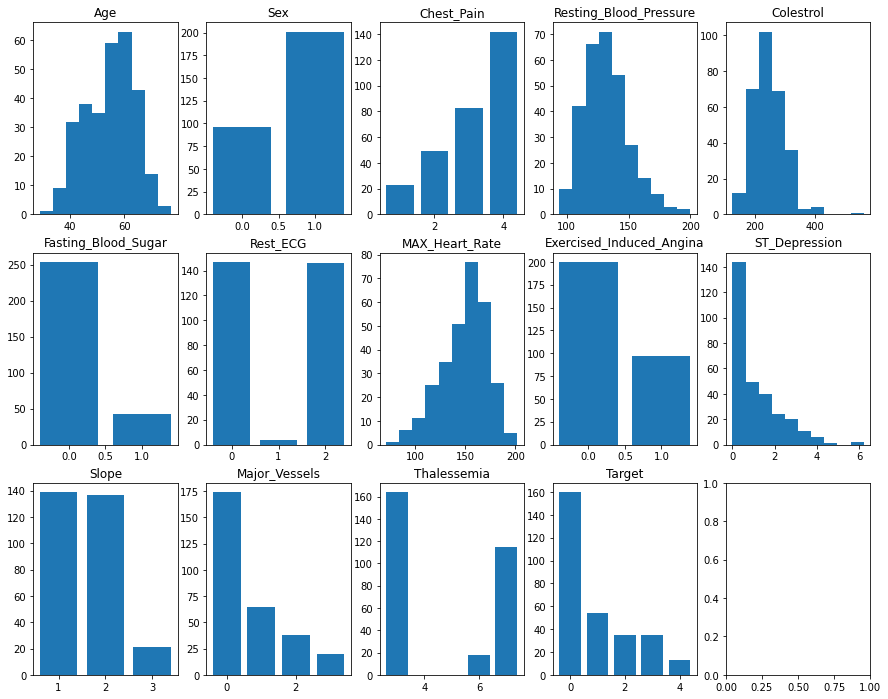

In [3]:
# Remove rows containing invalid values
data = raw_data.drop(invalid_rows, axis = 0)
# convert data type of cols Major_Vessels and Thalessemia from object to int
data.Major_Vessels = data.Major_Vessels.values.astype(np.int64)
data.Thalessemia = data.Thalessemia.values.astype(np.int64)
data.apply(np.unique, axis=0)
# check distribution of each features 
fig, axes = plt.subplots(3, int(np.ceil(len(data.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    if len(np.unique(data[col])) < 10:
        x, y = np.unique(data[col], return_counts=True)
        axes[i].bar(x, y)
    else:
        axes[i].hist(data[col], bins=10)
    axes[i].set_title(col)
    

# Feature preprocessing

In [4]:
data.columns

Index(['Age', 'Sex', 'Chest_Pain', 'Resting_Blood_Pressure', 'Colestrol',
       'Fasting_Blood_Sugar', 'Rest_ECG', 'MAX_Heart_Rate',
       'Exercised_Induced_Angina', 'ST_Depression', 'Slope', 'Major_Vessels',
       'Thalessemia', 'Target'],
      dtype='object')

In [116]:
def one_hot(inputs, sample=None):
    if sample is None:
        sample=inputs
    onehot_encoder = OneHotEncoder()
    onehot_encoder.fit(sample)
    return onehot_encoder.transform(inputs).toarray()

In [5]:
# one-hot encoding categorical features
cat_features = ['Chest_Pain', 'Rest_ECG', 'Thalessemia']

cp_onehot = one_hot(data.Chest_Pain.values.reshape(-1, 1))
cp_onehot = pd.DataFrame(cp_onehot, columns=['asy_ang', 'aty_ang', 'no_ang', 'typ_ang'])
data = pd.concat([data, cp_onehot], axis=1, join='inner')

Rest_ECG_onehot = one_hot(data.Rest_ECG.values.reshape(-1, 1))
Rest_ECG_onehot = pd.DataFrame(Rest_ECG_onehot, columns=['lefg_ven', 'normal_type', 't_or_st'])
data = pd.concat([data, Rest_ECG_onehot], axis=1, join='inner')

thal_onehot = one_hot(data.Thalessemia.values.reshape(-1, 1))
thal_onehot = pd.DataFrame(thal_onehot, columns=['normal', 'fixed', 'reversable'])
data = pd.concat([data, thal_onehot], axis=1, join='inner')

data = data.drop(cat_features, axis=1)

# Normalize data 
# Age categorized into 10 classes
num_cat=8
age_bins=np.linspace(18, 90, num_cat + 1)
ages = data.Age.values
for i in range(1, num_cat+1):
    ages[(data.Age <= age_bins[i]) & (data.Age > age_bins[i - 1])] = i
data.Age = ages
def min_max_norm(array):
    return (array - array.min()) / (array.max() - array.min())

def z_score(array):
    return (array - array.mean()) / array.std()

min_max_norm_list = ['Age', 'Resting_Blood_Pressure','Colestrol', 'MAX_Heart_Rate', 'ST_Depression',
                     'Major_Vessels']

for f in data.columns[:-1]:
    if f in min_max_norm_list:
        data[f] = min_max_norm(data[f])
        
data.Slope = data.Slope - 2
data=data.drop('Sex', axis=1)

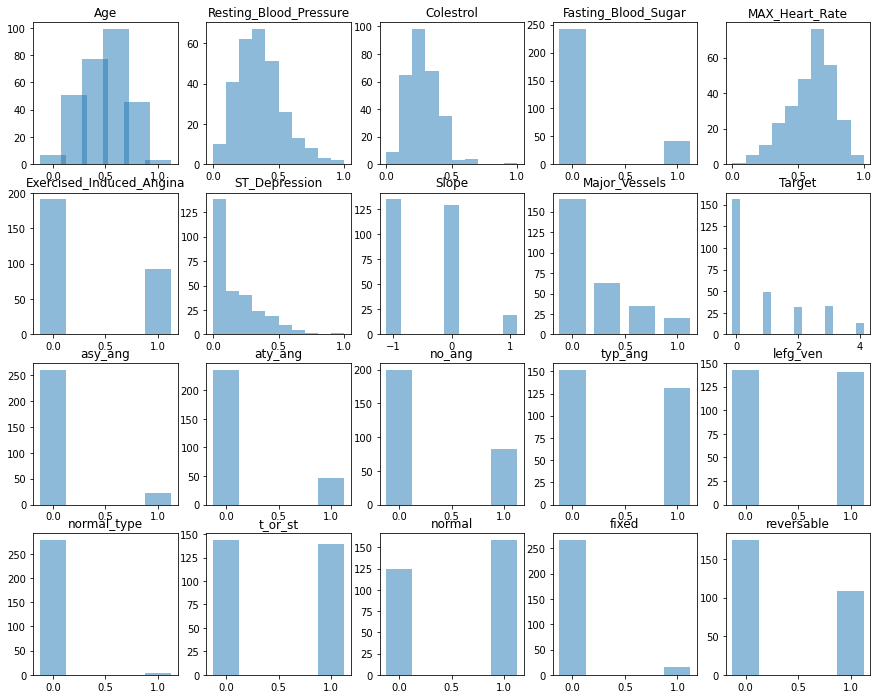

In [6]:
# check distribution of each features after normalization
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    if len(np.unique(data[col])) < 11:
        x, y = np.unique(data[col], return_counts=True)
        axes[i].bar(x, y, alpha=0.5, width=0.25)
    else:
        axes[i].hist(data[col], bins=10, alpha = 0.5)
    axes[i].set_title(col)
    

In [50]:
# Split into training set and testing set
def split_data(data, test_size=0.2, random_seed=42, stratify=True):
    X = data.drop('Target', axis=1)
    y = data.Target
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=y.values,
                                                            random_state=random_seed,
                                                            shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=None,
                                                            random_state=random_seed,
                                                            shuffle=True)
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)

## short conclusion
- Many features are discret
- Target is inbalanced between no-heart-disease target (target=0) and with-heart-disease target(target$\not=0$).
- Dataset is small

# Correlations of features

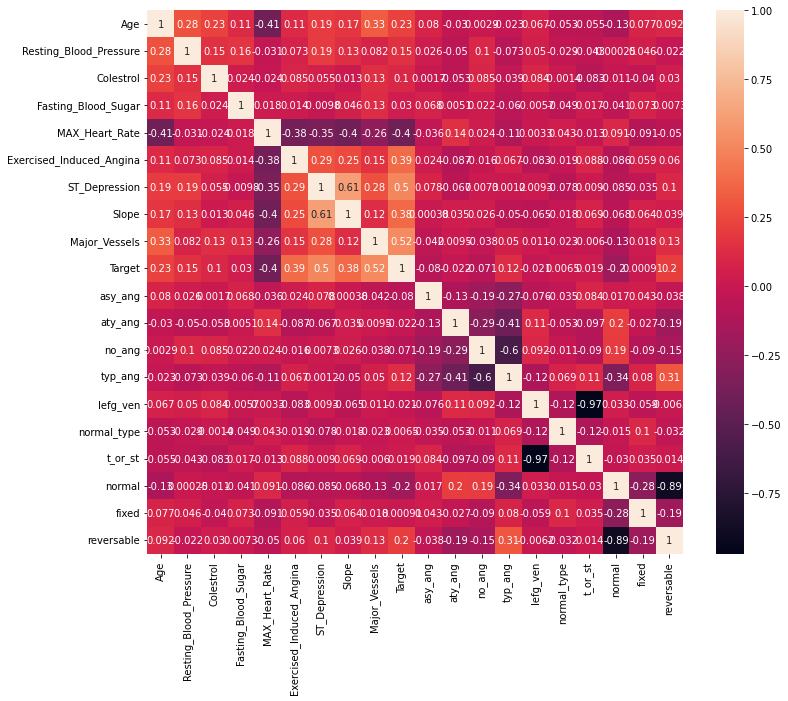

In [8]:
# correlation matrix
fig = plt.figure(figsize=(12,10))
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [9]:
# split data into zero target (no heart dieases) and non-zero target
data_w_hd = []
data.groupby(by='Target').apply(lambda x: data_w_hd.append(x) if all(x.Target!=0) else x)
data_w_hd = pd.concat(data_w_hd)
data_wo_hd = data[data.Target==0]

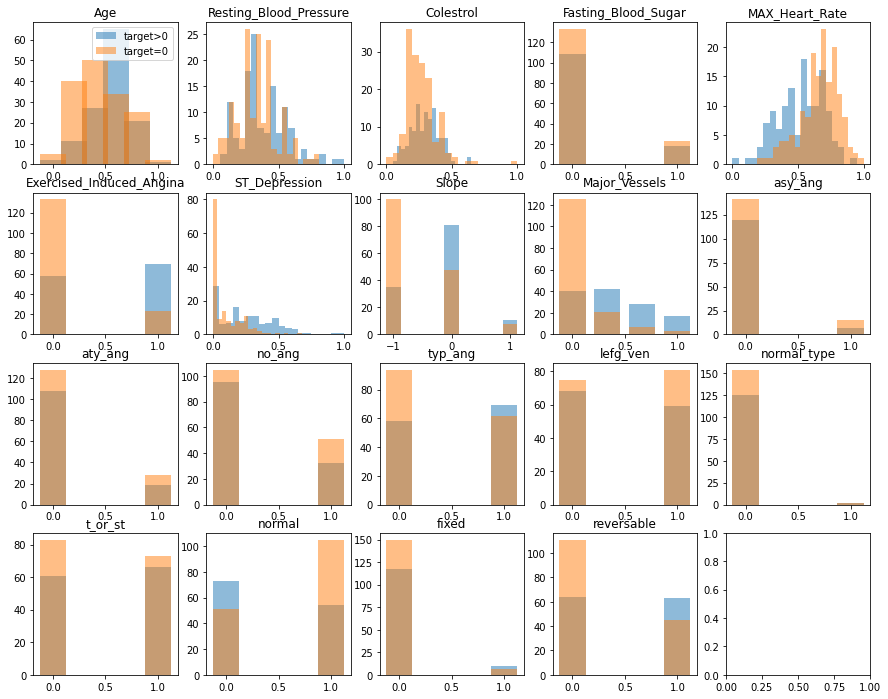

In [10]:
# check distribution of features 
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(data_w_hd[col])) < 10:
        x, y = np.unique(data_w_hd[col], return_counts=True)
        axes[i].bar(x, y, alpha=.5, width=0.25, label='target>0')
        x,y = np.unique(data_wo_hd[col], return_counts=True)
        axes[i].bar(x, y, alpha=0.5, width=0.25, label='target=0')
    else:
        axes[i].hist(data_w_hd[col], bins=20, alpha=0.5, label='target>0')
        axes[i].hist(data_wo_hd[col], bins=20, alpha=0.5, label='target=0')
    axes[i].set_title(col)

axes[0].legend()

In [11]:
data_w_hd_diff = data_w_hd.copy()
data_w_hd.Target=1

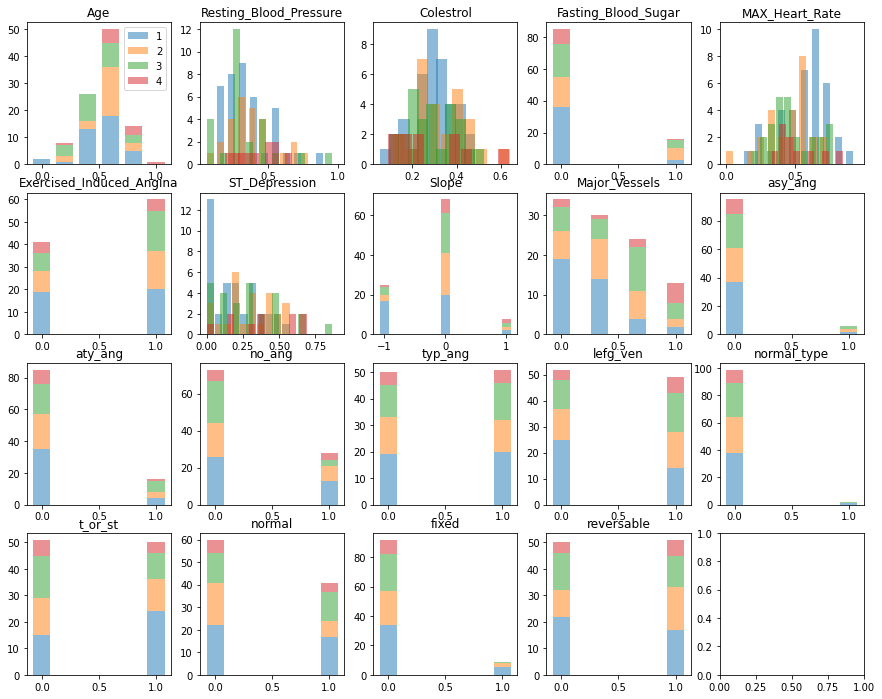

In [12]:
fig, axes = plt.subplots(4, int(np.ceil(len(data.columns)/4)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(X_train[col])) < 10:
        val = np.unique(X_train[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_train[y_train==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.15, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_train[y_train==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
axes[0].legend()

# Try different methods with naive data

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR

In [14]:
# KNN 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
print(np.mean(knn_predictions == y_test))

0.5789473684210527


In [15]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print(np.mean(rf_predictions == y_test))

0.5964912280701754


In [16]:
# Neural Network
dnn_classifier = MLPClassifier(hidden_layer_sizes = [64]*10, max_iter=1000)
dnn_classifier.fit(X_train, y_train)
dnn_predictions = dnn_classifier.predict(X_test)
print(np.mean(dnn_predictions == y_test))

0.5614035087719298


In [17]:
def confusion_matrix_display(ytrue, ypred, ax=None):
    cf_matrix = confusion_matrix(ytrue, ypred)
    ax = ConfusionMatrixDisplay(cf_matrix/np.sum(cf_matrix, axis=1)[:, np.newaxis])
    ax.plot()

0.543859649122807


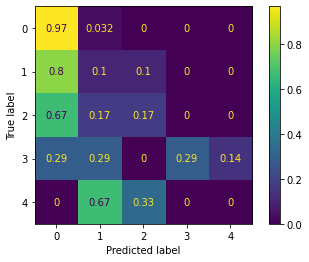

In [18]:
print(np.mean(y_test == 0))
confusion_matrix_display(y_test.values, rf_predictions)

# Finding 1
- Imbalancing between target=0 and other classes makes classification more difficult.

# Way 1: Balance dataset with SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
resampled_X_train, resampled_y_train = sm.fit_resample(X_train, y_train)

<BarContainer object of 5 artists>

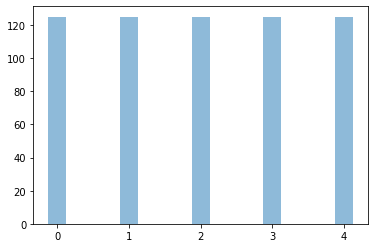

In [20]:
val, count = np.unique(resampled_y_train, return_counts=True)
plt.bar(val, count, alpha=.5, label='target', width=0.25)

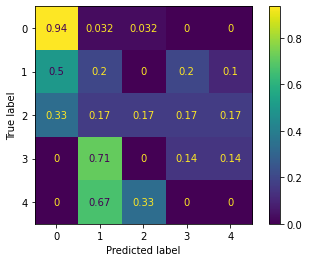

In [21]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(resampled_X_train, resampled_y_train)
rf_predictions = rf_classifier.predict(X_test)
confusion_matrix_display(y_test.values, rf_predictions)

# Way 2: Binary Classification first

In [22]:
# split data with non-zero target and zero target
binary_dataset = pd.concat([data_wo_hd, data_w_hd])
X_train, X_test, y_train, y_test = split_data(binary_dataset, test_size=0.2)

0.9122807017543859


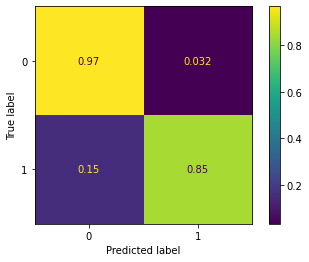

In [23]:
from sklearn.svm import SVC
svc = SVC(C=1, kernel='linear')
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
confusion_matrix_display(y_test.values, svm_pred)
print(np.mean(svm_pred == y_test))

0.8245614035087719


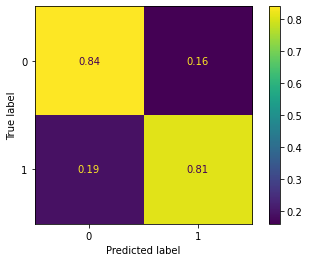

In [24]:
# greate accuracy to predict target = 0
dnn_classifier = MLPClassifier(hidden_layer_sizes = [100]*2, max_iter=2000, learning_rate_init=0.0001)
dnn_classifier.fit(X_train, y_train)
dnn_predictions = dnn_classifier.predict(X_test)
confusion_matrix_display(y_test.values, dnn_predictions)
print(np.mean(dnn_predictions == y_test))

0.8245614035087719


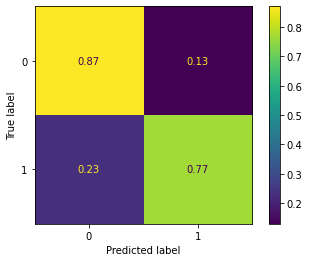

In [26]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print(np.mean(rf_predictions == y_test))
confusion_matrix_display(y_test.values, rf_predictions)

# Classifier for non-0 target 

In [27]:
multi_dataset = data_w_hd_diff.copy()
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.2)

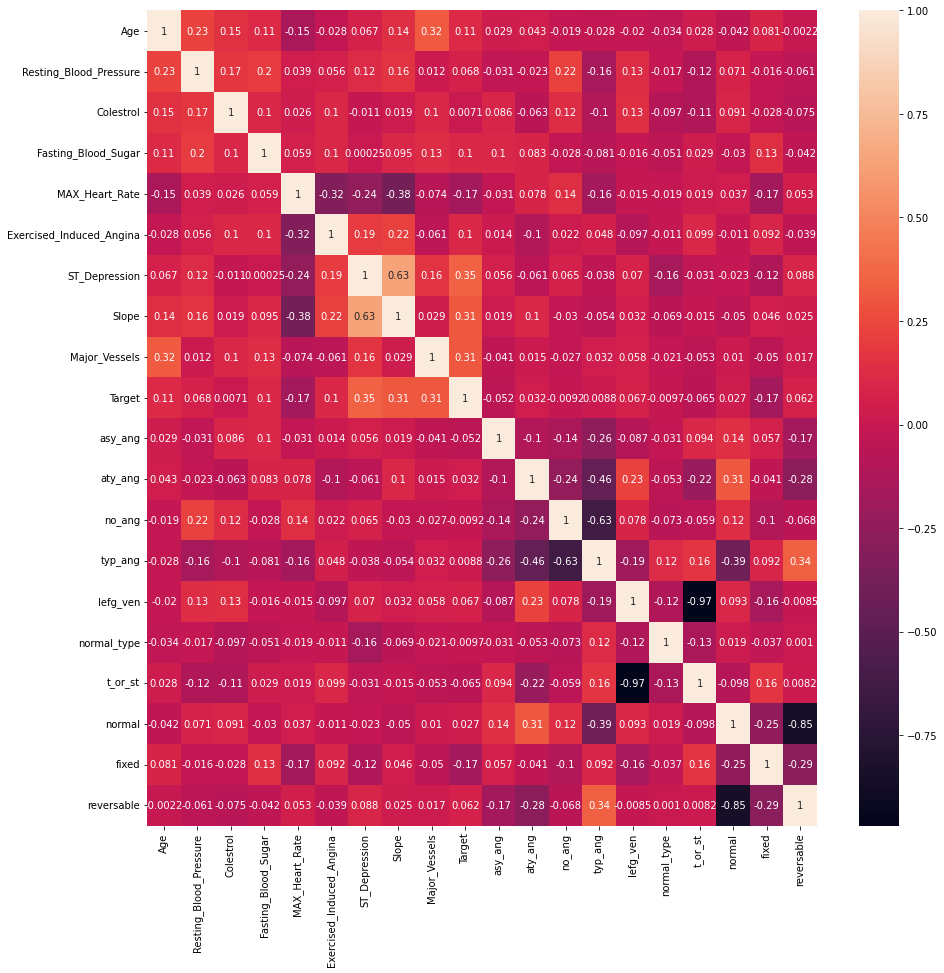

In [28]:
# correlation matrix
fig = plt.figure(figsize=(15,15))
corrMatrix = multi_dataset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations

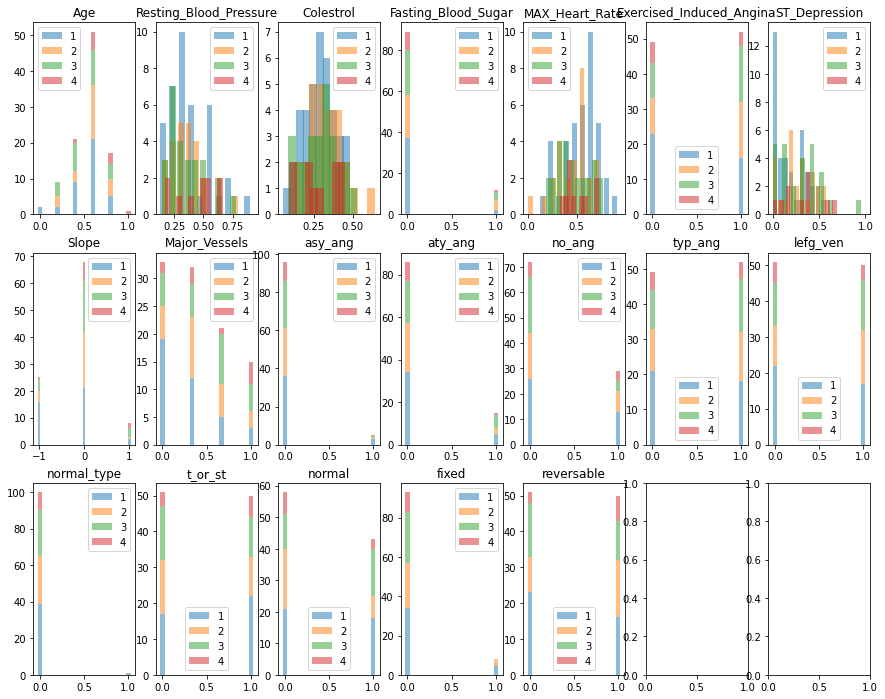

In [29]:
fig, axes = plt.subplots(3, int(np.ceil(len(X_train.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(multi_dataset[col])) < 10:
        val = np.unique(X_train[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_train[y_train==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_train[y_train==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()

0.4230769230769231


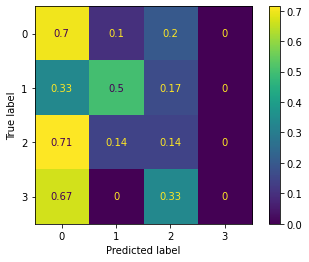

In [30]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
model.fit(X_train, y_train)
pred = model.predict(X_test)
confusion_matrix_display(y_test.values, pred)
print(np.mean(y_test.values == pred))

In [35]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import torch.optim as optim

In [36]:
class MLP(nn.Module):
    def __init__(self, input_channels, output_channels, num_hidden_layers=3):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.layers = [nn.Linear(input_channels, 64)]
        for l in range(num_hidden_layers):
            self.layers.append(nn.Linear(64, 64))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(64, output_channels))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)
    
    def predict(self, x):
        with torch.no_grad():
            ypred = self.layers(x)
            ypred = F.softmax(ypred, dim=1).argmax(dim=-1) + 1
        return ypred

In [37]:
def focal_loss(input_tensor, target_tensor, gamma=1, alpha=None):
    input_soft = F.softmax(input_tensor, dim=1)
    log_input_soft = F.log_softmax(input_tensor, dim=1)
    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)
    if alpha is None:
        alpha = torch.ones_like(weight)
    focal = -alpha * weight * log_input_soft

    loss = torch.einsum('bc...,bc...->b...', (target_tensor.to(torch.double), focal.to(torch.double)))

    return loss.mean()

In [58]:
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.5, stratify=False)

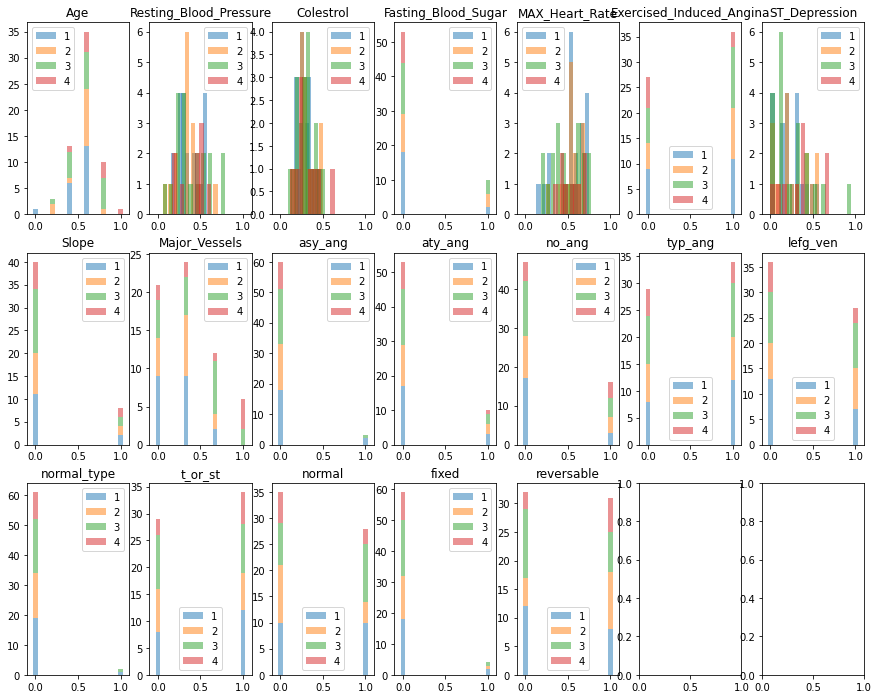

In [59]:
data_plot_x = X_train
data_plot_y = y_train

fig, axes = plt.subplots(3, int(np.ceil(len(data_plot_x.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data_plot_x.columns):
    if len(np.unique(data_plot_x[col])) < 10:
        val = np.unique(data_plot_x[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(data_plot_x[data_plot_y==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(data_plot_x[data_plot_y==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([-0.1, 1.1])

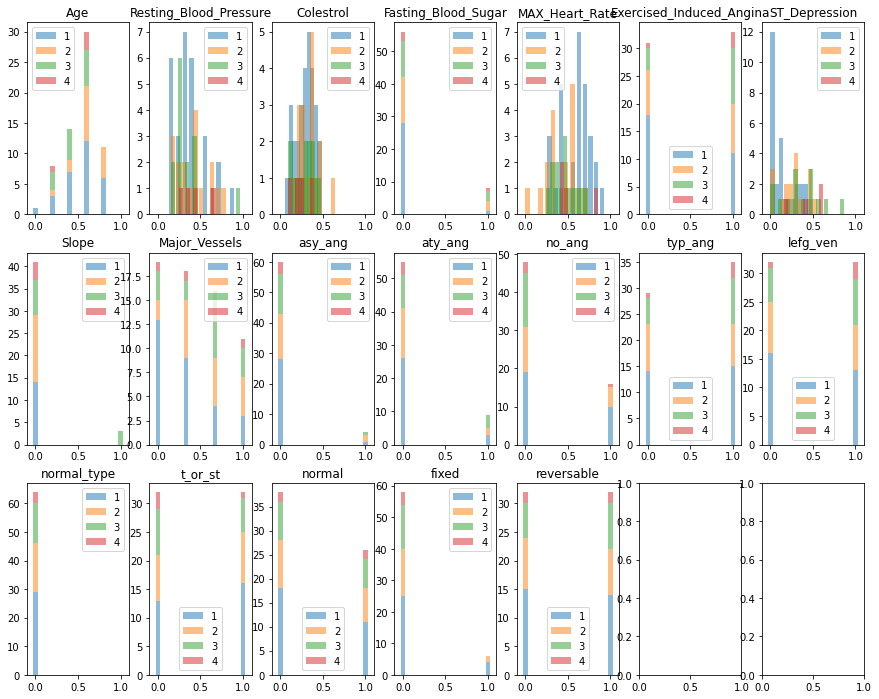

In [60]:
data_plot_x = X_test
data_plot_y = y_test

fig, axes = plt.subplots(3, int(np.ceil(len(data_plot_x.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(data_plot_x.columns):
    if len(np.unique(data_plot_x[col])) < 10:
        val = np.unique(data_plot_x[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(data_plot_x[data_plot_y==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(data_plot_x[data_plot_y==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([-0.1, 1.1])

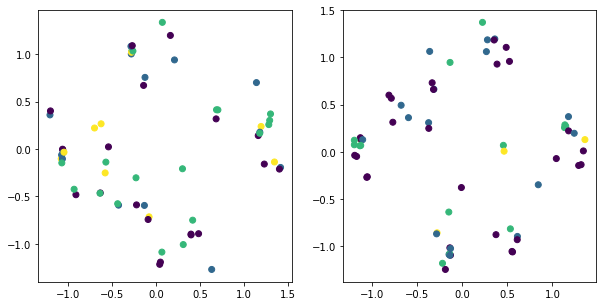

In [82]:
pca = PCA(n_components=10)
x_train_emb=pca.fit_transform(X_train.values)
x_test_emb = pca.fit_transform(X_test.values)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(x_train_emb[:, 0], x_train_emb[:, 1], c=y_train.values)
axes[1].scatter(x_test_emb[:, 0], x_test_emb[:, 1], c=y_test.values)


(array([20.,  0.,  0., 15.,  0.,  0., 19.,  0.,  0.,  9.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

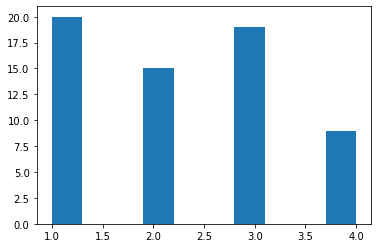

In [83]:
plt.hist(y_train)

(array([29.,  0.,  0., 17.,  0.,  0., 14.,  0.,  0.,  4.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

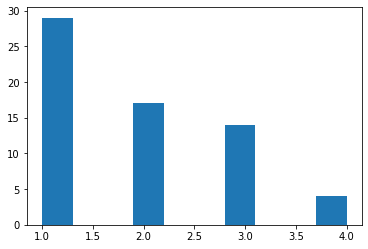

In [84]:
plt.hist(y_test)

In [96]:
len(X_train.columns)
X_train.values.shape

(101, 19)

In [122]:
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.7, stratify=False, random_seed=1)
tensor_x = torch.from_numpy(X_train.values).float()
tensor_y = torch.from_numpy(y_train.values - 1).float()
tensor_y_onehot = torch.from_numpy(one_hot(tensor_y.view(-1, 1))).float()
tensor_x_test = torch.from_numpy(X_test.values).float()
tensor_y_test = torch.from_numpy(y_test.values - 1).float()
tensor_y_test_onehot = torch.from_numpy(one_hot(tensor_y_test.view(-1, 1), sample=tensor_y.view(-1, 1))).float()

dataset = TensorDataset(tensor_x, tensor_y_onehot) # create your datset
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [123]:
n_epochs = 300
criterion = nn.BCELoss()
y_u, y_c = np.unique(y_train, return_counts=True)

gamma = 1
mlp = MLP(input_channels=tensor_x.size()[1], output_channels=len(y_u), num_hidden_layers=10)
optimizer = optim.Adam(mlp.parameters(), lr=0.0005)

weights = (1 - (y_c / y_c.sum())) * 0.5
alpha = torch.from_numpy(weights).view(1, -1)
losses = []
losses_val = []
accuracy_train = []
accuracy_test = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, d in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = d
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = mlp(inputs)
        loss = focal_loss(output, labels, gamma=gamma, alpha=alpha)
            
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    losses.append(running_loss / (i + 1))
    running_loss = 0.0
    # validation
    with torch.no_grad():
        losses_val.append(focal_loss(mlp(tensor_x_test), tensor_y_test_onehot, gamma=gamma, 
                                     alpha=alpha))
    accuracy_train.append(np.mean(y_train.values == mlp.predict(tensor_x).detach().numpy()))
    accuracy_test.append(np.mean(y_test.values == mlp.predict(tensor_x_test).detach().numpy()))
        
        

print('Finished Training')

Finished Training


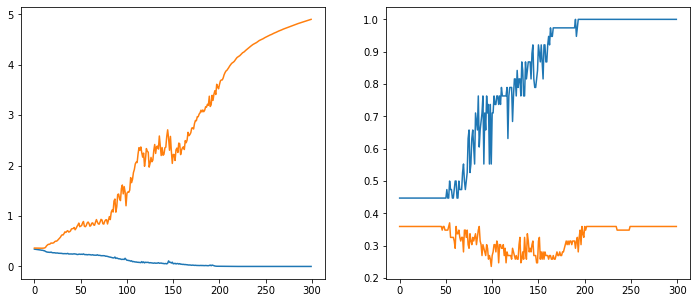

In [124]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax = axes[0]
ax.plot(losses)
ax.plot(losses_val)
ax = axes[1]
ax.plot(accuracy_train)
ax.plot(accuracy_test)

0.0


/var/folders/w4/1lw8p_xd5f52x1rm8hb4syg00000gn/T/ipykernel_20626/1860690931.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax = ConfusionMatrixDisplay(cf_matrix/np.sum(cf_matrix, axis=1)[:, np.newaxis])


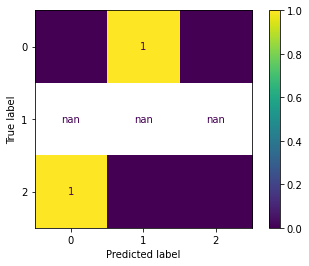

In [120]:
ypred = mlp.predict(tensor_x_test)
confusion_matrix_display(y_test.values, ypred)
print(np.mean(y_test.values == ypred.detach().numpy()))

1.0


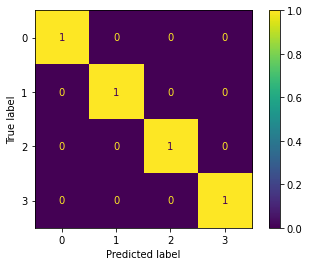

In [121]:
ypred = mlp.predict(tensor_x)
confusion_matrix_display(y_train.values, ypred)
print(np.mean(y_train.values == ypred.detach().numpy()))

In [102]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations

In [103]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [ layers.Dense(32, activation='relu'),
                      layers.Dense(32, activation='relu')]
        self.linear1 = layers.Dense(64, activation='relu')
        self.linear2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(1, activation = 'linear')

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oij = tf.concat([densei, densej], 1)
        oij = self.linear1(oij)
        oij = self.linear2(oij)
        oij = self.output_layer(oij)
        output = layers.Activation('sigmoid')(oij)
        return output


In [104]:
# put data into pairs
def pair_data(features, scores=None, q=1, return_prob=True):
    xi = []
    xj = []
    pij = []
    pair_id = []
    pair_query_id = []
    query_idx = np.arange(len(features))
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(features[i])
        xj.append(features[j])
        if return_prob:
            if scores[i] == scores[j]:
                pij.append(0.5)
            elif scores[i] > scores[j]:
                pij.append(1)
            else:
                pij.append(0)
    xi = np.array(xi)
    xj = np.array(xj)
    pij = np.array(pij)
    pair_query_id = np.array(pair_query_id)
    if return_prob:
        return xi, xj, pij, pair_id, pair_query_id
    else:
        return xi, xj, pair_id, pair_query_id

In [105]:
def restore_score_from_rank(result, pair_id):
    predict = np.zeros(np.asarray(pair_id).max()+1)
    a = np.where(np.logical_and(result <= 0.25, result >=0))[0]
    for pairs in np.asarray(pair_id)[a]:
        predict[pairs[1]] = predict[pairs[0]] + 1
    b = np.where(np.logical_and(result >=.75, result <=1))[0]
    for pairs in np.asarray(pair_id)[b]:
        predict[pairs[0]] = predict[pairs[1]] + 1
    c = np.where(np.logical_and(result < 0.75, result>0.25))[0]
    for pairs in np.asarray(pair_id)[c]:
        if predict[pairs[0]] == predict[pairs[1]]:
            continue
        elif min(predict[pairs[0]], predict[pairs[1]]) == 0:
            x = max(predict[pairs[0]], predict[pairs[1]])
            predict[pairs[0]] = x
            predict[pairs[1]] = x
    return predict

In [106]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
multi_dataset = data_w_hd_diff.copy()
X = multi_dataset.drop('Target', axis=1).values.shape
y = multi_dataset.Target.values
X_train, X_test, y_train, y_test = split_data(multi_dataset, test_size=0.2, random_seed=1234)
# balance data
oversample = SVMSMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
features = X_train_over.copy().values
scores = y_train_over.values - 1
xi, xj, pij, pair_id, pair_query_id = pair_data(features, scores=scores, q=1, return_prob=True)

xi_train, xi_val, xj_train, xj_val, pij_train, pij_val, pair_id_train, pair_id_val = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)
features = X_test.values
scores = y_test.values - 1
xi_test, xj_test, pij_test, pair_id_test, _ = pair_data(features, scores=scores, return_prob=True)

In [107]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, 
                      epochs=50, batch_size=10, 
                      validation_data=([xi_val, xj_val], pij_val),shuffle=True)

2022-02-05 17:17:13.559645: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
768/768 [==============================] - 3s 3ms/step - loss: 0.4926 - val_loss: 0.3986
Epoch 2/50
768/768 [==============================] - 2s 3ms/step - loss: 0.3439 - val_loss: 0.3204
Epoch 3/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2785 - val_loss: 0.2741
Epoch 4/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2462 - val_loss: 0.2415
Epoch 5/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2280 - val_loss: 0.2347
Epoch 6/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2194 - val_loss: 0.2174
Epoch 7/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2088 - val_loss: 0.2172
Epoch 8/50
768/768 [==============================] - 2s 2ms/step - loss: 0.2021 - val_loss: 0.2163
Epoch 9/50
768/768 [==============================] - 2s 3ms/step - loss: 0.1996 - val_loss: 0.2038
Epoch 10/50
768/768 [==============================] - 2s 2ms/step - loss: 0.1953 - val_loss: 0.2048

0.22857142857142856


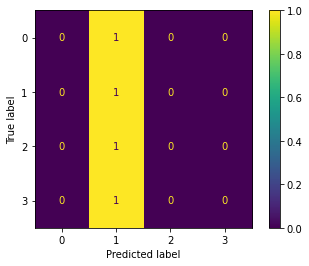

In [263]:
features = X_train.values
scores = y_train.values - 1
xi_test, xj_test, pij_test, pair_id_test, _ = pair_data(features, scores=scores, return_prob=True)
result = ranknet.predict(([xi_test, xj_test]))
predictions = restore_score_from_rank(result, pair_id_test)
predictions[predictions>3]=3
confusion_matrix_display(y_train.values, predictions+1)
print(np.mean(y_train.values == (predictions+1)))
#plt.scatter(pij_test, result, s=1)

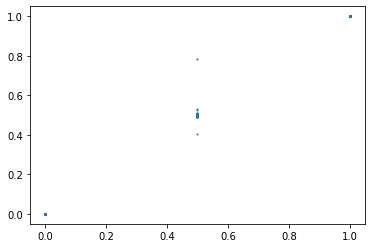

In [261]:
result = ranknet.predict([xi_val, xj_val])
plt.scatter(pij_val, result, s=1)
#predictions = restore_score_from_rank(result, pair_id)
#predictions[predictions>3]=3
#confusion_matrix_display(y_train_over.values, predictions+1)
#print(np.mean(y_train_over.values == (predictions)+1))

In [418]:
ranknet.evaluate([xi_test, xj_test], pij_test)

11/11 [==============================] - 0s 2ms/step - loss: 2.0733


2.073272705078125

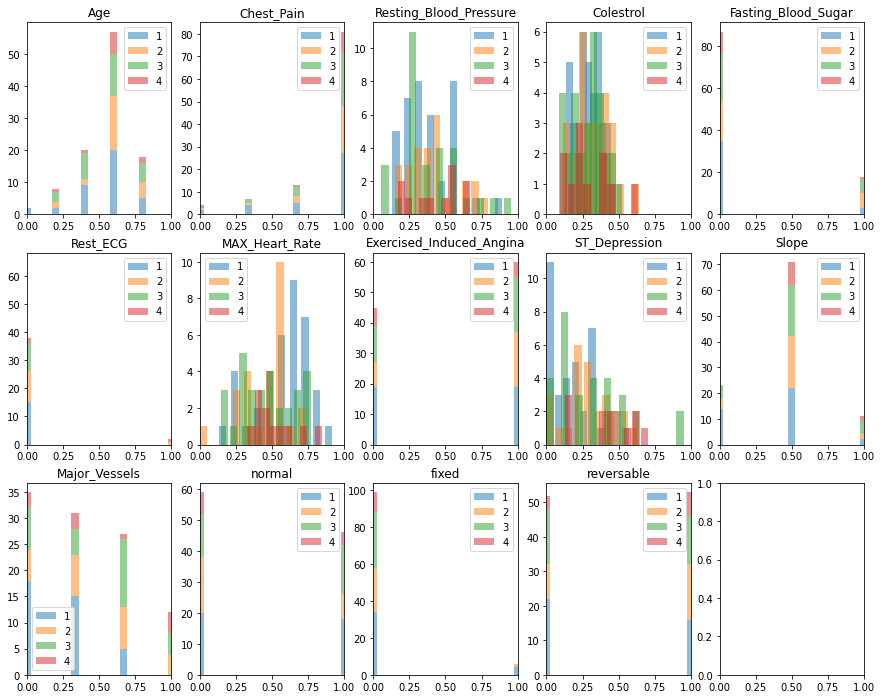

In [325]:
fig, axes = plt.subplots(3, int(np.ceil(len(X_train.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_train.columns):
    if len(np.unique(multi_dataset[col])) < 10:
        val = np.unique(X_train[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_train[y_train==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_train[y_train==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([0,1])

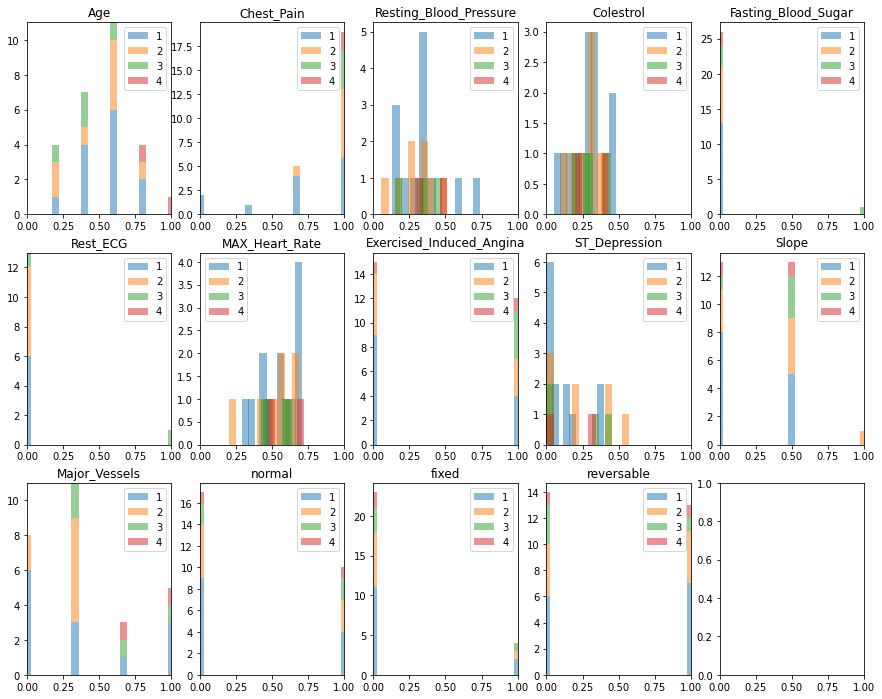

In [326]:
fig, axes = plt.subplots(3, int(np.ceil(len(X_test.columns)/3)), figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(X_test.columns):
    if len(np.unique(X_test[col])) < 10:
        val = np.unique(X_test[col])
        last_count = np.zeros_like(val)
        for t in range(1,5):
            count = np.zeros_like(val)
            x, y = np.unique(X_test[y_test==t][col], 
                             return_counts=True)
            count[np.where(np.in1d(val, x))[0]] = y 
            axes[i].bar(val, count, alpha=.5, label=str(t), width=0.05, bottom = last_count)
            last_count += count
    else:
        for t in range(1,5):
            axes[i].hist(X_test[y_test==t][col],
                         bins=10, alpha=0.5, label=str(t), width=0.05)
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].set_xlim([0,1])